<a href="https://colab.research.google.com/github/Saarle/Regression-Project/blob/main/Regression_Project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Regression Project**





In [187]:
import pandas as pd
import numpy as np
import  matplotlib.pyplot as plt
import warnings
import seaborn as sns
import re

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor , plot_tree

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
%matplotlib inline

def csv_drive_path_generatoer(url):
 '''
 Help in read csv file directly from google drive.
 Make sure the csv format is standard.
 url:str - path to csv file example:
   url = 'https://drive.google.com/file/d/126JPZ3lYwdLyJ2d_7jxM9jMtZaOlF-Ld/view?usp=sharing'
 return : str
 '''
 path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
 return path

In [277]:
# read the data
path = csv_drive_path_generatoer('https://drive.google.com/file/d/1R3vBFIn6YPrgpvyAADCY0yAYthaGy9NF/view?usp=sharing')
path_y = csv_drive_path_generatoer('https://drive.google.com/file/d/10wLZgOF00TY5Kmg0d_rn_agoEAFMVbwB/view?usp=sharing')
X = pd.read_csv(path)
y=  pd.read_csv(path_y)


In [278]:
# order the columns 
X.rename(columns = {"Unnamed: 0.1": "Id1",
                    "Unnamed: 0": "Id2",
                    "Education Level":"Education_Level",
                    "Job Title": "Job_Title",
                   "Years of Experience": "Years_of_Experience"},
                    inplace=True)

column_order =['id','Id1','Id2','Gender','Education_Level','Job_Title','Years_of_Experience','Country','Race','height','weight','professionalism']
X = X[column_order]

# **EDA**


In [279]:
# set id as index
data = X.join(y)
data.sort_values(by='id')

,id,Id1,Id2,Gender,Education_Level,Job_Title,Years_of_Experience,Country,Race,height,weight,professionalism,Unnamed: 0,Salary
417,0,0,0,NaN,bachelor,software|enginee,120.0,RazShmuelykingdom,NayaCollegegeek,2.492683,200.000000,160.0,0,90000.0
2839,1,1,1,NaN,master,data|analys,120.0,RazShmuelykingdom,NayaCollegegeek,2.480525,200.000000,84.0,1,65000.0
5076,4,4,4,M,master,directo,22.0,us,Asian,1.522019,105.799514,1040.0,4,200000.0
3739,5,5,5,M,bachelor,marketing|analys,4.0,us,Hispanic,1.949831,49.868702,58.0,5,55000.0
2351,6,6,6,F,master,product|manage,13.0,us,Asian,1.537399,87.847470,504.0,6,120000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2487,6697,6697,6697,F,master's|degr,senior|product|marketing|manage,20.0,u,White,2.271163,106.654680,969.0,6697,190000.0
689,6698,6698,6698,M,bachelor's|degr,junior|sales|representativ,7.0,canad,Asian,2.394349,73.157479,222.0,6698,75000.0
1872,6699,6699,6699,F,p,director|of|marketin,22.0,u,Mixed,1.642822,96.333417,980.0,6699,200000.0
2225,6702,6702,6702,M,master's|degr,marketing|manage,15.0,chin,Korean,2.238909,108.154402,644.0,6702,140000.0


In [7]:
class DataPipeline:
    def __init__(self, data):
        self.data = data.copy() 
        

In [280]:
# check and drop duplicated columns 

def drop_duplicate_columns(data):
    columns_to_keep = data.T[~data.T.duplicated()].index

    return data[columns_to_keep]

data = drop_duplicate_columns(data)   

In [281]:
data.describe()

,id,Years_of_Experience,height,weight,professionalism,Salary
count,5363.000000,5360.000000,5363.000000,5361.000000,5360.000000,5358.000000
mean,3362.789856,9.660914,2.002573,66.937032,316.371735,115624.128779
std,1934.196180,6.438456,0.292412,18.346610,304.989037,52754.945428
min,0.000000,1.000000,1.500276,13.637206,0.000000,500.000000
25%,1692.500000,5.000000,1.750666,53.891837,84.000000,70000.000000
50%,3363.000000,8.000000,2.001049,64.747191,217.000000,115000.000000
75%,5044.500000,13.000000,2.262341,78.374262,451.000000,160000.000000
max,6703.000000,120.000000,2.499932,200.000000,2040.000000,250000.000000


In [282]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5363 entries, 0 to 5362
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   5363 non-null   int64  
 1   Gender               5359 non-null   object 
 2   Education_Level      5360 non-null   object 
 3   Job_Title            5361 non-null   object 
 4   Years_of_Experience  5360 non-null   float64
 5   Country              5363 non-null   object 
 6   Race                 5363 non-null   object 
 7   height               5363 non-null   float64
 8   weight               5361 non-null   float64
 9   professionalism      5360 non-null   float64
 10  Salary               5358 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 461.0+ KB


In [283]:
# set id as index
data.set_index('id' , inplace= True)
data.sort_values(by='id')

,Gender,Education_Level,Job_Title,Years_of_Experience,Country,Race,height,weight,professionalism,Salary
id,,,,,,,,,,
0,NaN,bachelor,software|enginee,120.0,RazShmuelykingdom,NayaCollegegeek,2.492683,200.000000,160.0,90000.0
1,NaN,master,data|analys,120.0,RazShmuelykingdom,NayaCollegegeek,2.480525,200.000000,84.0,65000.0
4,M,master,directo,22.0,us,Asian,1.522019,105.799514,1040.0,200000.0
5,M,bachelor,marketing|analys,4.0,us,Hispanic,1.949831,49.868702,58.0,55000.0
6,F,master,product|manage,13.0,us,Asian,1.537399,87.847470,504.0,120000.0
...,...,...,...,...,...,...,...,...,...,...
6697,F,master's|degr,senior|product|marketing|manage,20.0,u,White,2.271163,106.654680,969.0,190000.0
6698,M,bachelor's|degr,junior|sales|representativ,7.0,canad,Asian,2.394349,73.157479,222.0,75000.0
6699,F,p,director|of|marketin,22.0,u,Mixed,1.642822,96.333417,980.0,200000.0


In [284]:
# drop rows with nulls values 

def drop_na(data):
    # (data[data.isnull().any(axis=1)])
    data.dropna(inplace = True)

drop_na(data)

<Axes: >

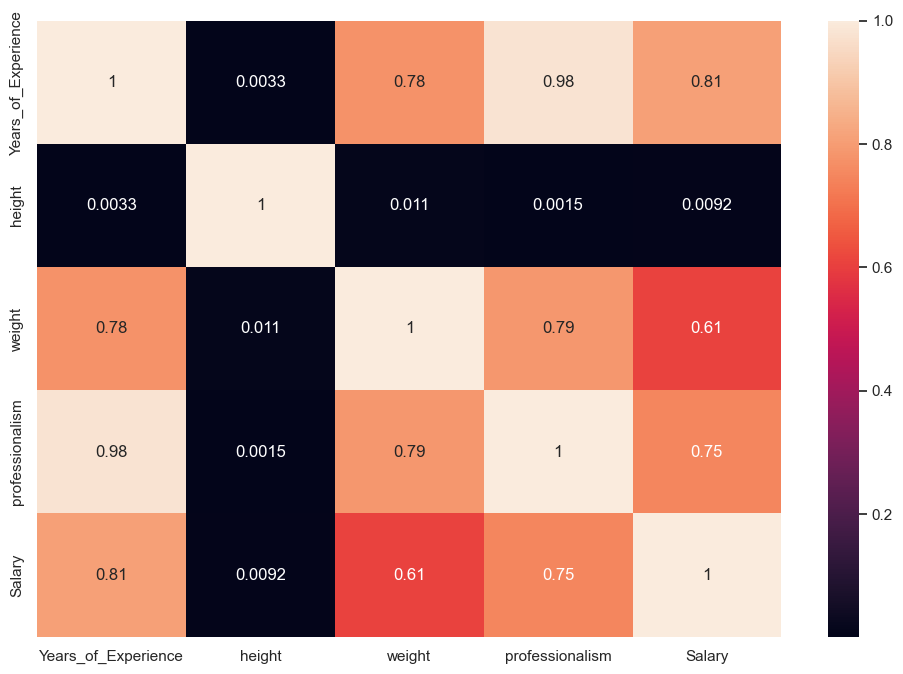

In [285]:
cor = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(cor , annot= True)

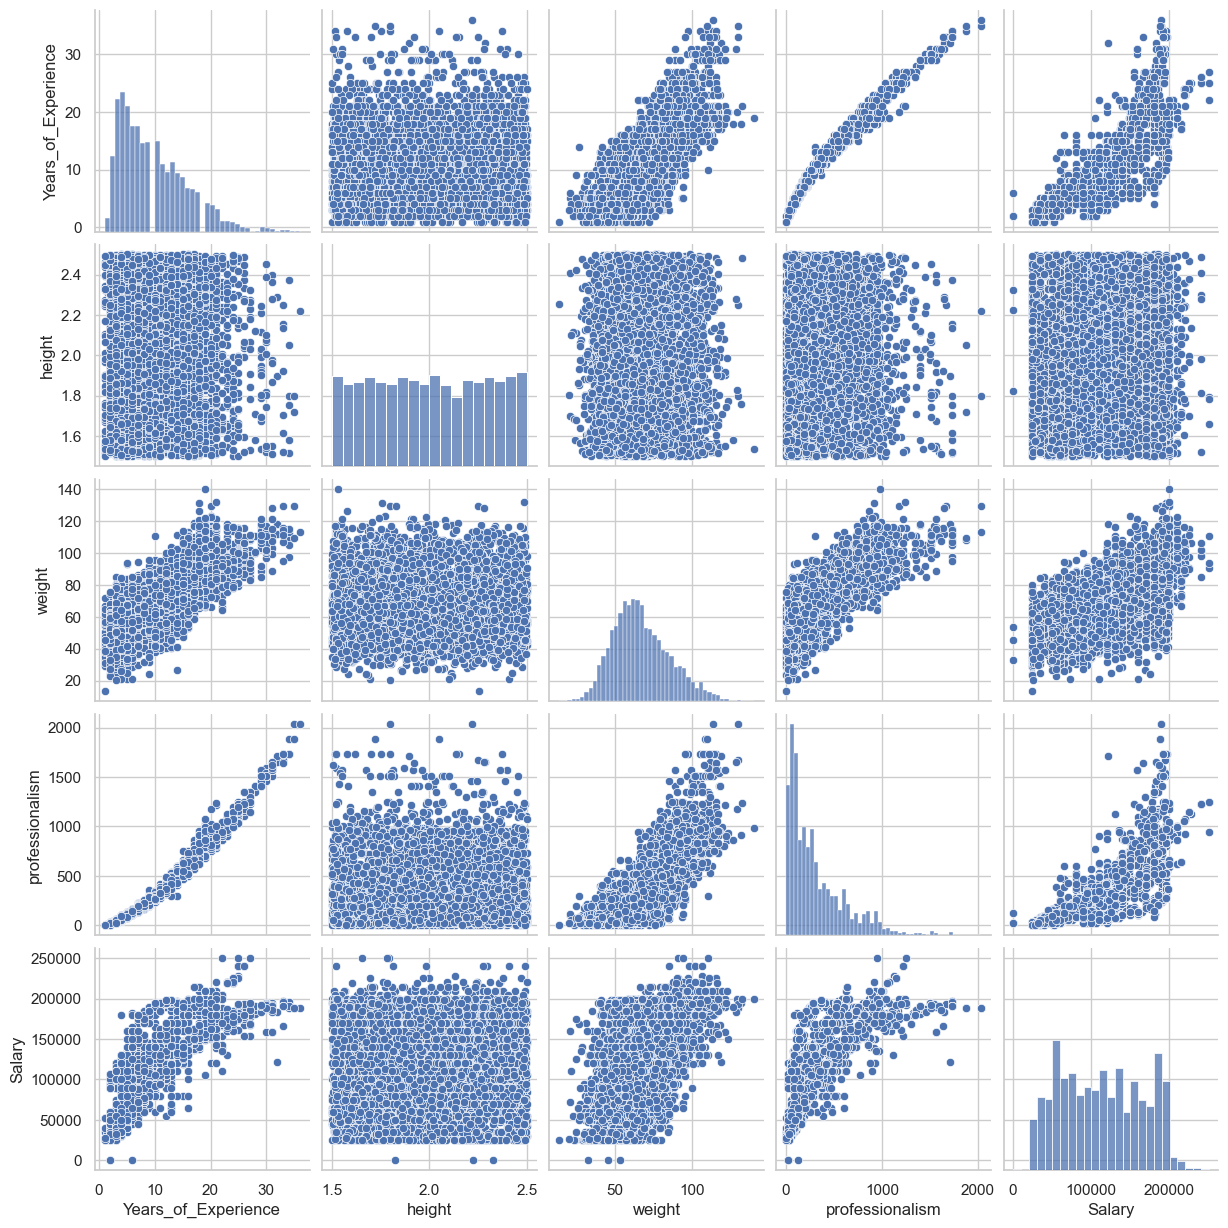

In [286]:
# sns.pairplot(data,hue = 'Gender')
sns.pairplot(data)

In [287]:
# check the sum od rows per gender
print(data.groupby('Gender').size())

# drop the gender O from the data
# data = data.loc[data['Gender']!='O']

Gender
F    2402
M    2941
O      12
dtype: int64


<Figure size 800x600 with 0 Axes>

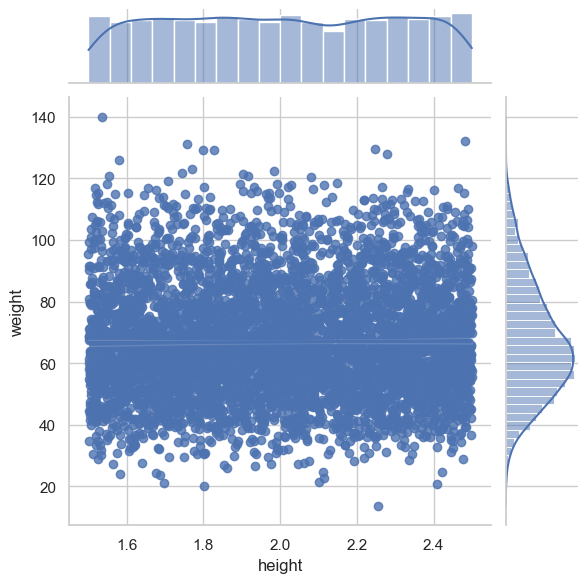

In [288]:
plt.figure(figsize=(8, 6))
sns.jointplot(x='height', y='weight', data=data, kind='reg')

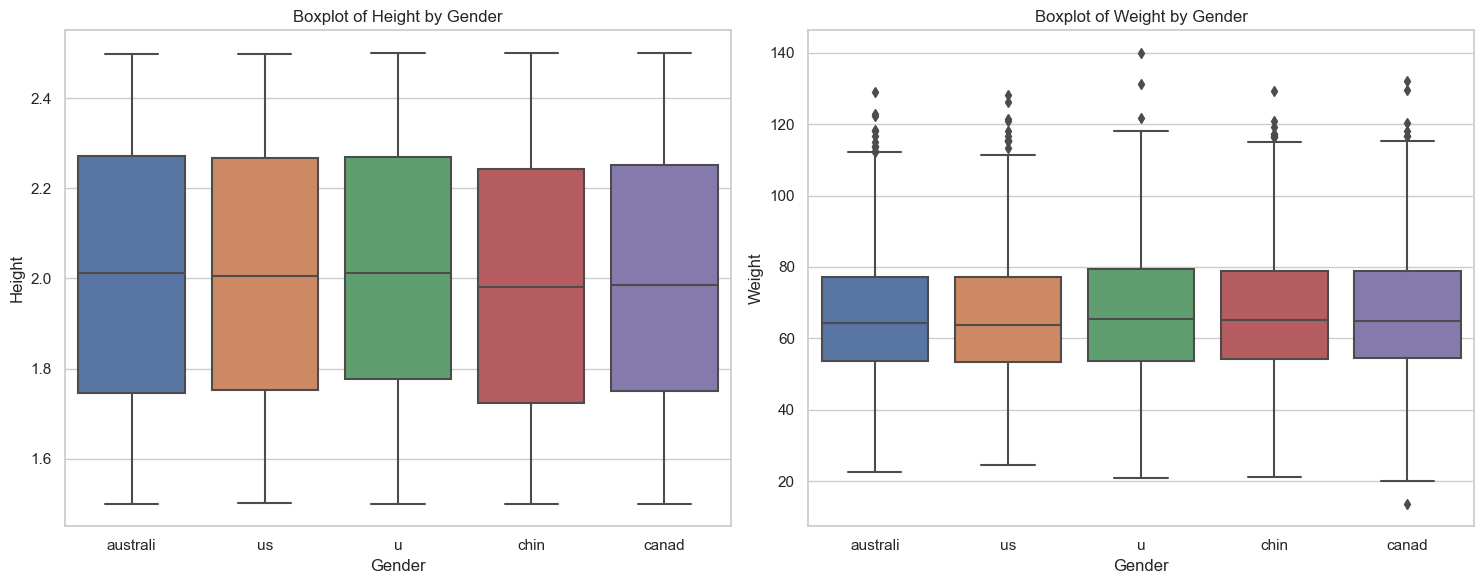

In [205]:
# Create two separate subplots for each box plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Create the first box plot for "height"
sns.boxplot(data=data, x="Country", y="height", ax=axes[0])
axes[0].set_title('Boxplot of Height by Gender')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Height')

# Create the second box plot for "weight"
sns.boxplot(data=data, x="Country", y="weight", ax=axes[1])
axes[1].set_title('Boxplot of Weight by Gender')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Weight')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

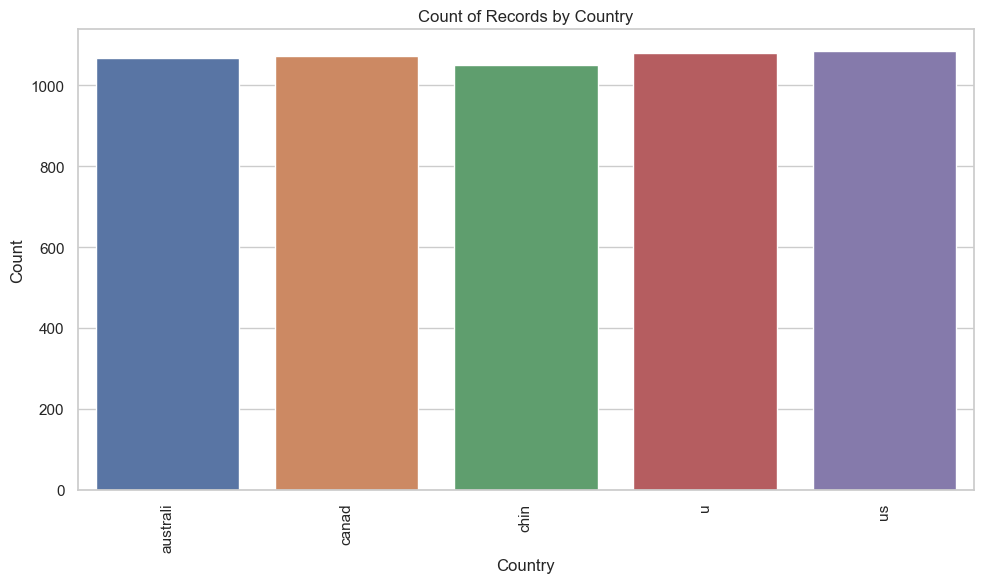

In [206]:
country = data.groupby('Country').size().reset_index(name='Count')

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(data=country, x='Country', y='Count')
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Count of Records by Country')
plt.tight_layout()

<Axes: xlabel='Education_Level', ylabel='Salary'>

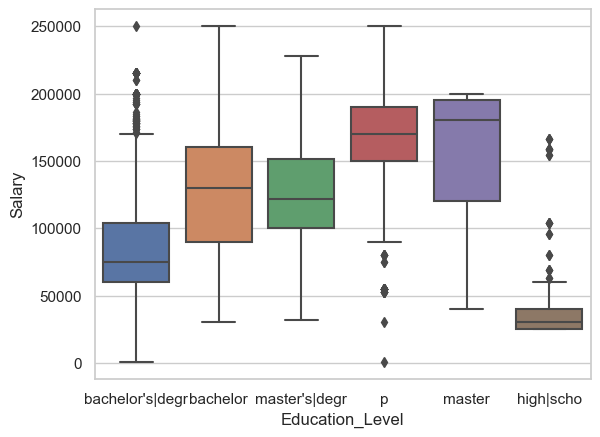

In [207]:
sns.boxplot(x='Education_Level',y='Salary',data=data)

<Axes: xlabel='Gender', ylabel='Salary'>

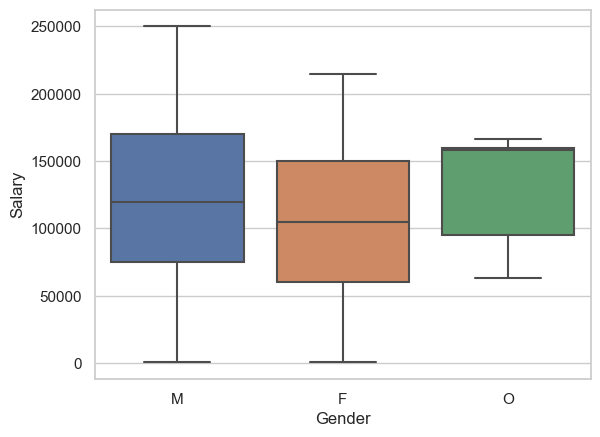

In [229]:
sns.boxplot(x='Gender',y='Salary',data=data)

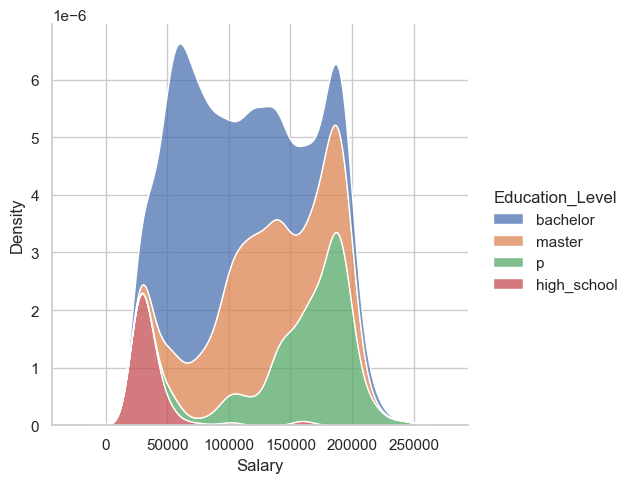

In [150]:
sns.displot(data=data, x="Salary", hue="Education_Level", multiple="stack",kind="kde")

In [293]:
edocation = data.groupby('Education_Level')['Salary'].median().reset_index()
data['Education_Level'] = data['Education_Level'].map(edocation.set_index('Education_Level')['Salary'])

data

,Gender,Education_Level,Job_Title,Years_of_Experience,Country,Race,height,weight,professionalism,Salary,job_title_frequency
id,,,,,,,,,,,
2477,M,75000.0,back|end|develope,24.0,australi,Asian,1.800316,95.021957,1150.0,175966.0,0.036788
76,F,130000.0,operations|manage,23.0,us,White,2.451414,87.456039,1100.0,160000.0,0.017367
64,M,130000.0,junior|accountan,2.0,australi,Australian,1.917509,56.997108,26.0,35000.0,0.000560
924,M,130000.0,data|analys,11.0,u,Welsh,2.160562,61.403169,279.0,195000.0,0.051914
242,F,130000.0,senior|product|manage,11.0,chin,Korean,1.794105,72.049210,380.0,120000.0,0.000747
...,...,...,...,...,...,...,...,...,...,...,...
354,F,130000.0,junior|business|development|associat,4.0,canad,Black,2.329507,64.070050,93.0,50000.0,0.001307
3677,M,170000.0,data|scientis,15.0,chin,White,1.945457,93.478548,546.0,140000.0,0.065359
6032,M,30000.0,delivery|drive,1.0,canad,Asian,1.575751,38.216264,0.0,28000.0,0.000934


In [360]:
edocation = data.groupby('Job_Title')['Salary'].median().reset_index()
data['Job_Title_med'] = data['Job_Title'].map(edocation.set_index('Job_Title')['Salary'])

data

,Gender,Education_Level,Job_Title,Years_of_Experience,Country,Race,height,weight,professionalism,Salary,job_title_frequency,Transformed_Job_Title,winsorized_salary,Job_Title_med
id,,,,,,,,,,,,,,
2477,M,75000.0,back|end|develope,24.0,australi,Asian,1.800316,95.021957,1150.0,175966.0,0.036788,3,175966.0,100000.0
76,F,130000.0,operations|manage,23.0,us,White,2.451414,87.456039,1100.0,160000.0,0.017367,95,160000.0,96000.0
64,M,130000.0,junior|accountan,2.0,australi,Australian,1.917509,56.997108,26.0,35000.0,0.000560,50,35000.0,40000.0
924,M,130000.0,data|analys,11.0,u,Welsh,2.160562,61.403169,279.0,195000.0,0.051914,17,195000.0,120000.0
242,F,130000.0,senior|product|manage,11.0,chin,Korean,1.794105,72.049210,380.0,120000.0,0.000747,142,120000.0,107500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,F,130000.0,junior|business|development|associat,4.0,canad,Black,2.329507,64.070050,93.0,50000.0,0.001307,53,50000.0,40000.0
3677,M,170000.0,data|scientis,15.0,chin,White,1.945457,93.478548,546.0,140000.0,0.065359,19,140000.0,162000.0
6032,M,30000.0,delivery|drive,1.0,canad,Asian,1.575751,38.216264,0.0,28000.0,0.000934,20,35000.0,28000.0


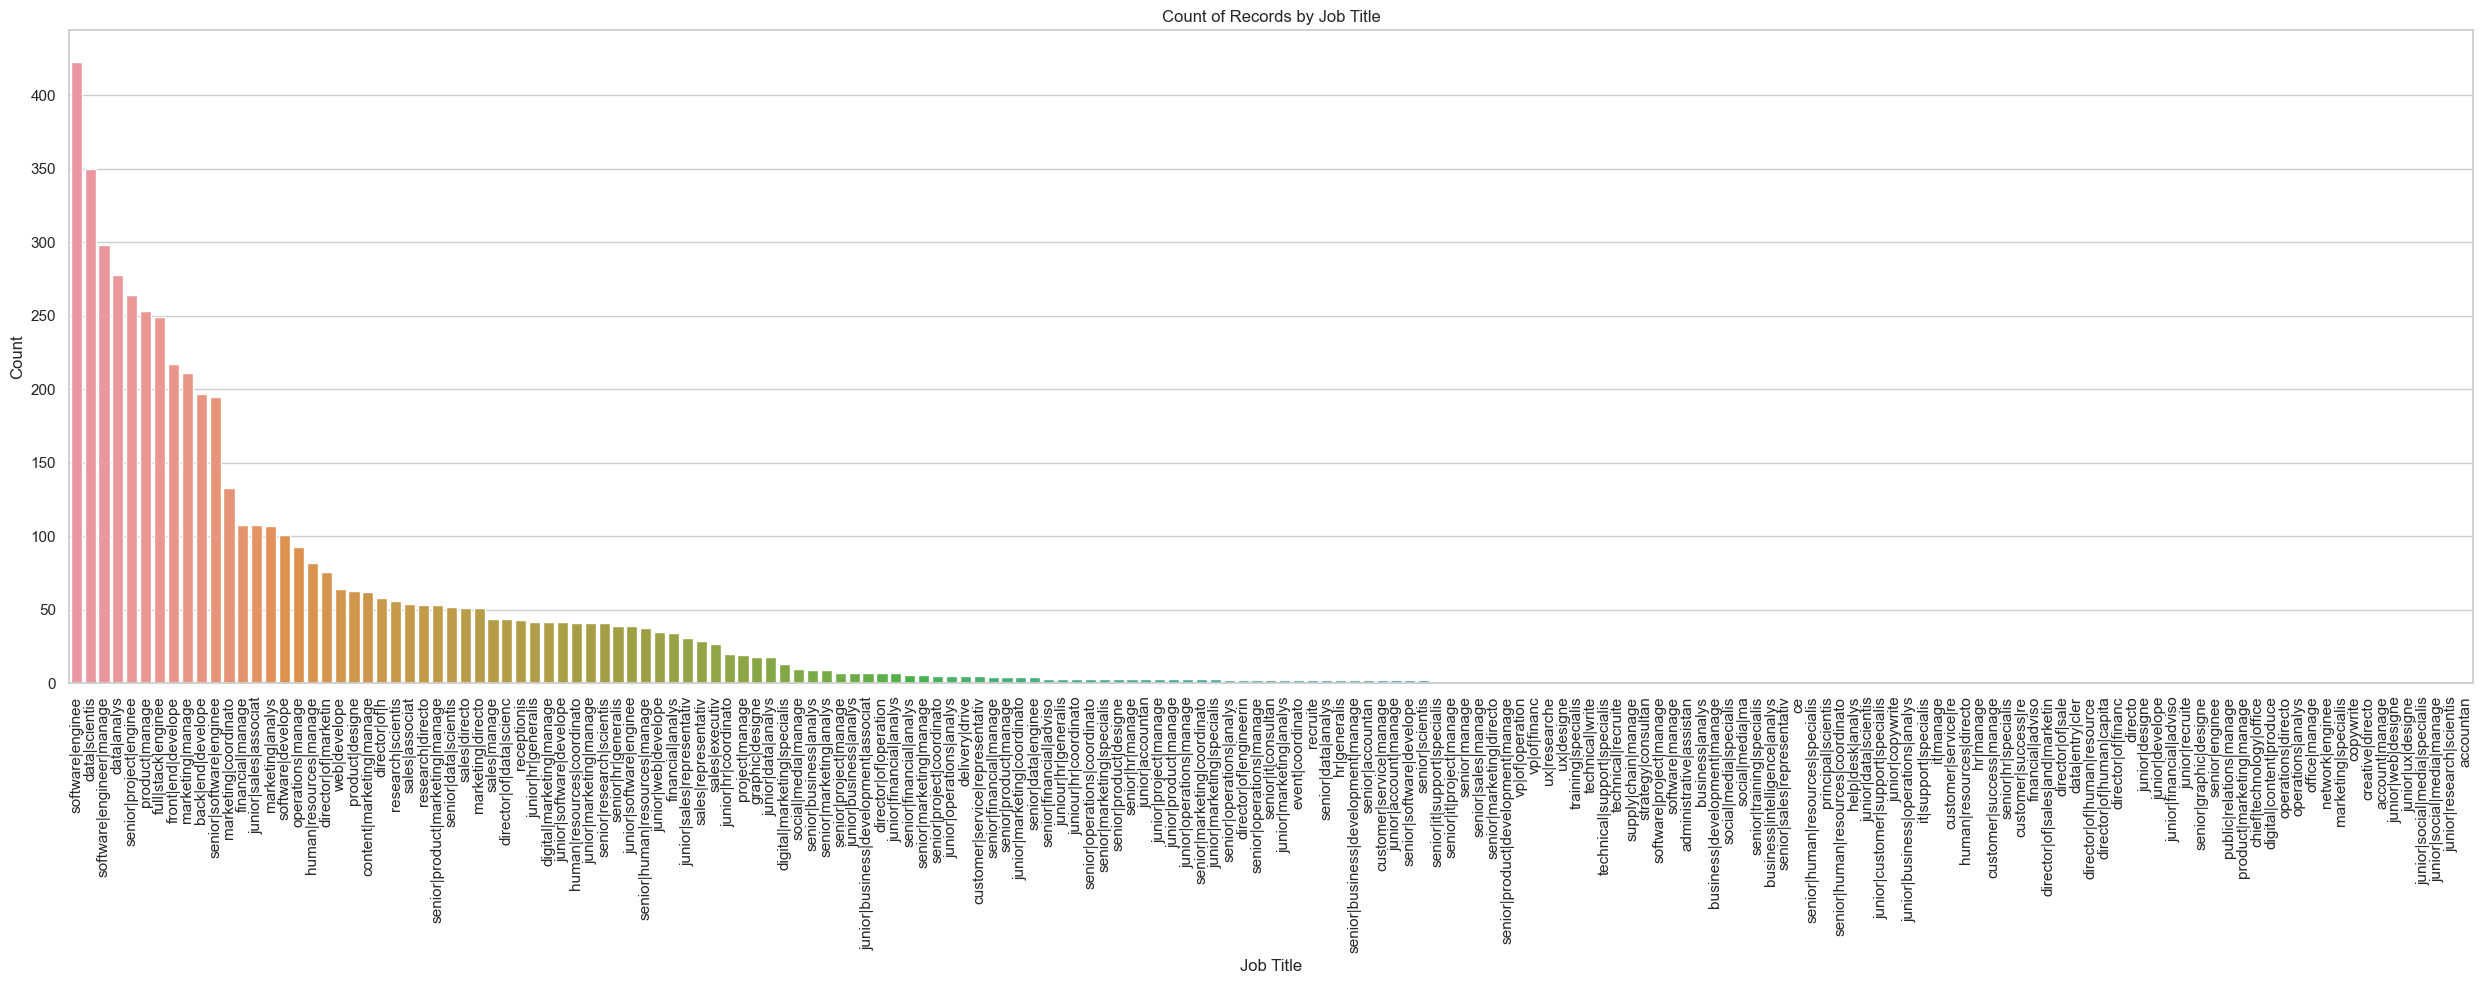

In [213]:
job = data.groupby('Job_Title').size().reset_index(name='count').sort_values(by='count' ,ascending=False)

sns.set(style="whitegrid")
plt.figure(figsize=(25, 10))
sns.barplot(data=job, x='Job_Title', y='count')
plt.xticks(rotation=90)
plt.xlabel('Job Title')
plt.ylabel('Count')
plt.title('Count of Records by Job Title')
plt.tight_layout()

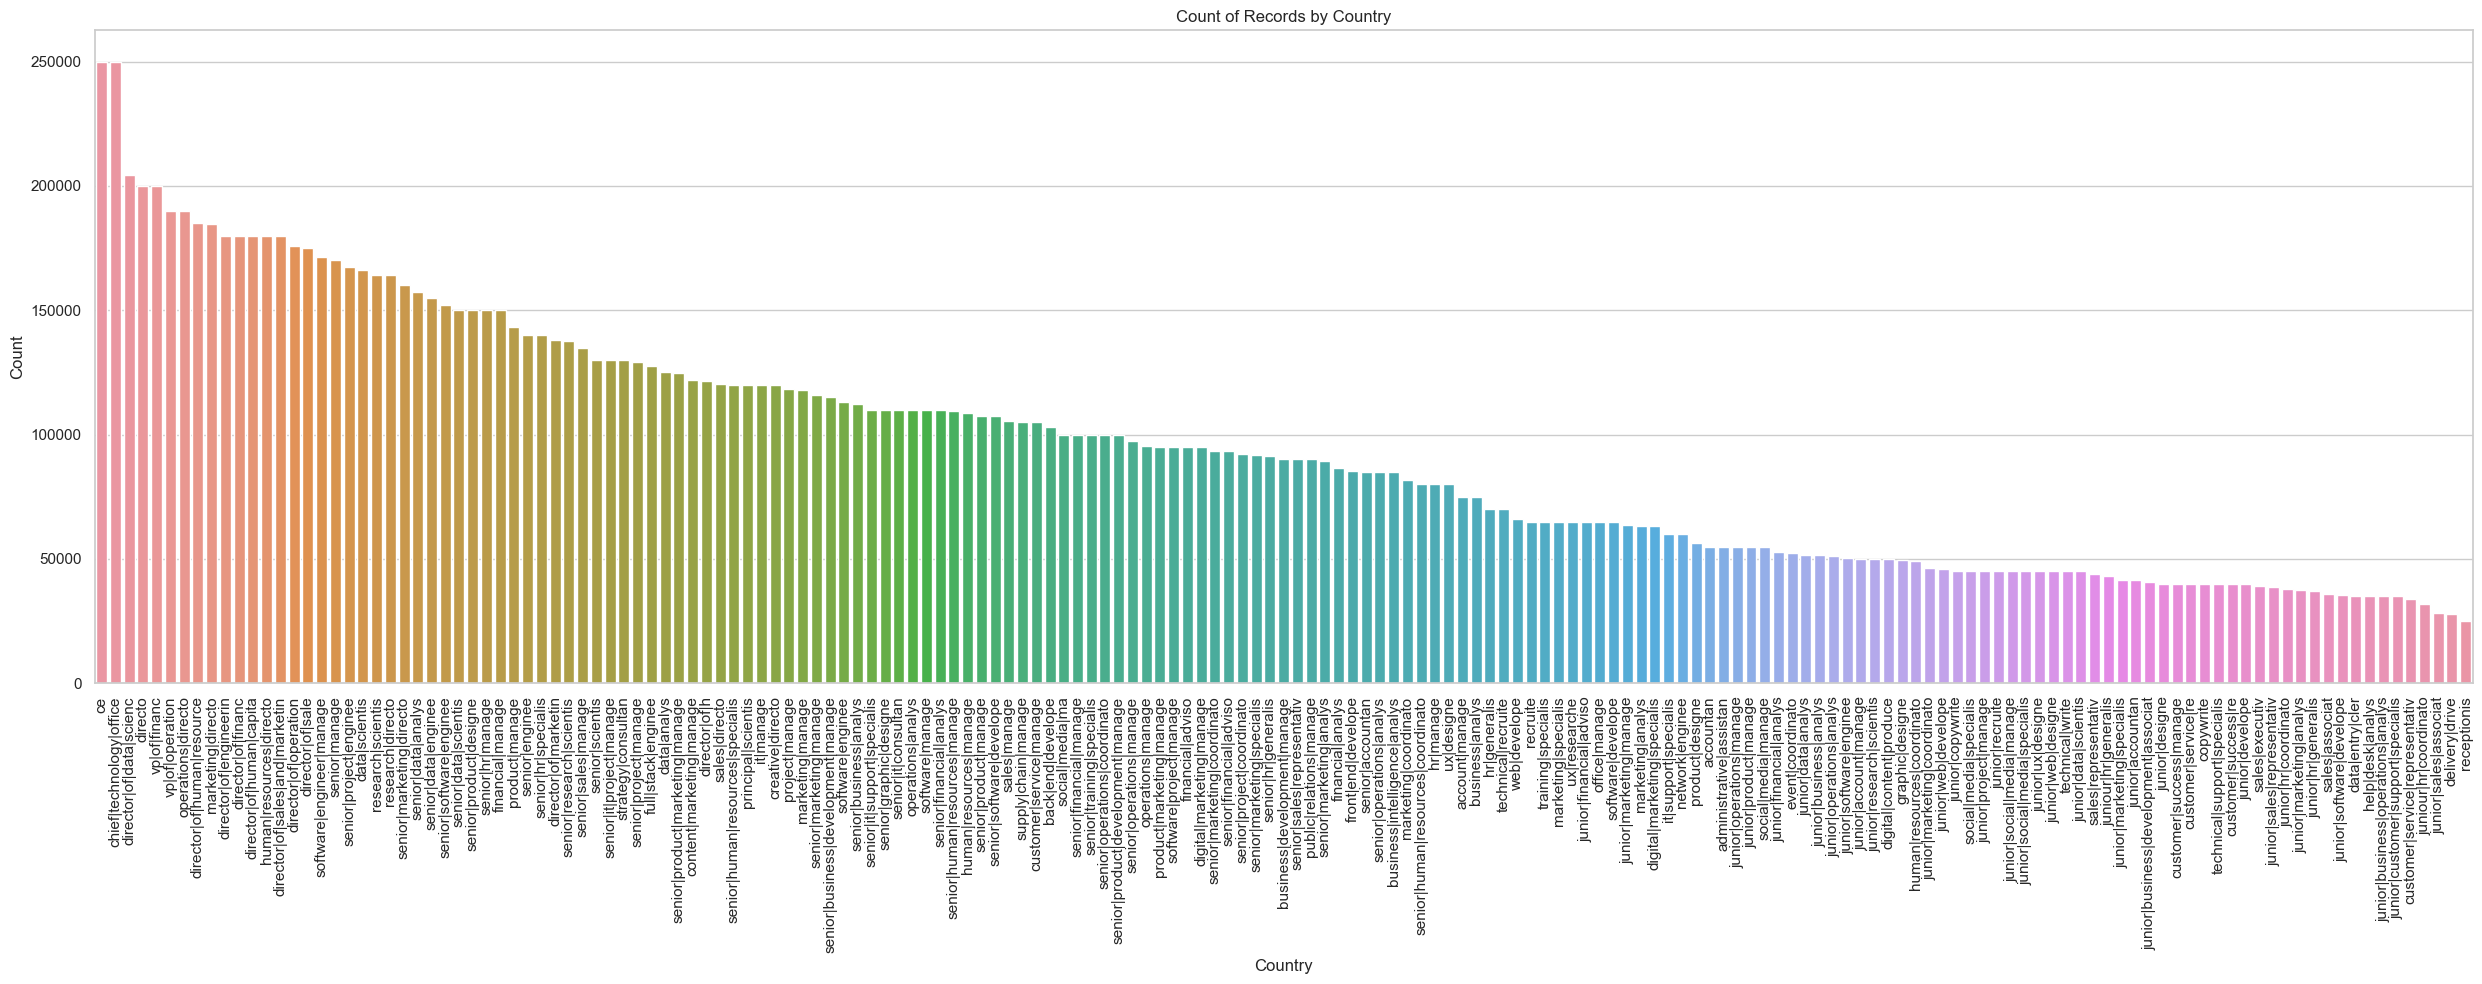

In [18]:
job = data.groupby('Job_Title')['Salary'].mean().reset_index(name='mean').sort_values(by='mean' ,ascending=False)

sns.set(style="whitegrid")
plt.figure(figsize=(25, 10))
sns.barplot(data=job, x='Job_Title', y='mean')
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Count of Records by Country')
plt.tight_layout()

# **Feature Engineering**

In [125]:



def clean_similar_strings(column):
    similar_strings_mapping = {
        r"bachelor's\|degr": "bachelor",
        r"master's\|degr": "master",
        r"high\|scho": "high_school",

        
        # Add more patterns and replacements as needed
    }

    cleaned_values = []
    for value in column:
        if isinstance(value, str):  # Check if the value is a string
            for pattern, replacement in similar_strings_mapping.items():
                value = re.sub(pattern, replacement, value, flags=re.IGNORECASE)
        cleaned_values.append(value)

    return cleaned_values


data['Education_Level']= clean_similar_strings(data['Education_Level'])

data.Education_Level.unique()

array(['bachelor', 'master', 'p', 'high_school'], dtype=object)

In [365]:
data.groupby('Education_Level').size().reset_index(name = 'count')


,Education_Level,count
0,30000.0,337
1,75000.0,1779
2,121716.0,1266
3,130000.0,600
4,170000.0,968
5,180000.0,227


In [314]:
from scipy.stats import mstats

# Apply Winsorization to the 'salary' column
winsorized_salary = mstats.winsorize(data['Salary'], limits=[0.05, 0.05])

# Create a new column with winsorized salary values
data['winsorized_salary'] = winsorized_salary

In [315]:

def transform_column_with_encoder(data_frame, column_name):
    le = preprocessing.LabelEncoder()
    le.fit(data_frame[column_name])
    transformed_column = le.transform(data_frame[column_name])
    return transformed_column
   
def add_encoded_data(data_frame, column_name):
    transformed_data = transform_column_with_encoder(data_frame, column_name)

    data_frame['Transformed_' + column_name] = transformed_data

# add_encoded_data(data, 'Job_Title')

data

,Gender,Education_Level,Job_Title,Years_of_Experience,Country,Race,height,weight,professionalism,Salary,job_title_frequency,Transformed_Job_Title,winsorized_salary
id,,,,,,,,,,,,,
2477,M,75000.0,back|end|develope,24.0,australi,Asian,1.800316,95.021957,1150.0,175966.0,0.036788,3,175966.0
76,F,130000.0,operations|manage,23.0,us,White,2.451414,87.456039,1100.0,160000.0,0.017367,95,160000.0
64,M,130000.0,junior|accountan,2.0,australi,Australian,1.917509,56.997108,26.0,35000.0,0.000560,50,35000.0
924,M,130000.0,data|analys,11.0,u,Welsh,2.160562,61.403169,279.0,195000.0,0.051914,17,195000.0
242,F,130000.0,senior|product|manage,11.0,chin,Korean,1.794105,72.049210,380.0,120000.0,0.000747,142,120000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,F,130000.0,junior|business|development|associat,4.0,canad,Black,2.329507,64.070050,93.0,50000.0,0.001307,53,50000.0
3677,M,170000.0,data|scientis,15.0,chin,White,1.945457,93.478548,546.0,140000.0,0.065359,19,140000.0
6032,M,30000.0,delivery|drive,1.0,canad,Asian,1.575751,38.216264,0.0,28000.0,0.000934,20,35000.0


In [340]:
# data = pd.get_dummies(data,columns=['Gender'])
data = data[(data['Salary']<200000) & (data['Salary']>20000)]

### **Linear Regression Model**

## Linear regression pipeline using gridearch

In [366]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

# Define your features and target variable
X = data[['Years_of_Experience', 'professionalism','Education_Level','job_title_frequency','Transformed_Job_Title']]
y = data.Salary

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the pipeline: pipeline
lnr_pipe = Pipeline([
    ('ssc', StandardScaler()),
    ('lnr', LinearRegression())
])

# Create a parameter grid for GridSearchCV for Linear Regression
lnr_params = {
    'lnr__fit_intercept': [True, False]
}

# Instantiate the GridSearchCV object for Linear Regression
gs_lnr = GridSearchCV(lnr_pipe, param_grid=lnr_params, scoring='neg_mean_squared_error', cv=5)

# Fit the GridSearchCV for Linear Regression to the training data
gs_lnr.fit(X_train, y_train)

# Get the best parameters and best RMSE for Linear Regression
best_lnr_params = gs_lnr.best_params_
best_lnr_rmse = np.sqrt(-gs_lnr.best_score_)

# Print the best parameters and lowest RMSE for Linear Regression
print("Best Linear Regression parameters found: ", best_lnr_params)
print("Best Linear Regression RMSE found: ", best_lnr_rmse)

# Create a parameter grid for GridSearchCV for Lasso Regression
lasso_params = {
    'lnr__fit_intercept': [True, False],
    'lnr__alpha': [0.001, 0.01, 0.1, 1.0, 10.0]  # Vary the alpha values for L1 regularization
}

# Create a Lasso Regression pipeline
lasso_pipe = Pipeline([
    ('ssc', StandardScaler()),
    ('lnr', Lasso())
])

# Instantiate the GridSearchCV object for Lasso Regression
gs_lasso = GridSearchCV(lasso_pipe, param_grid=lasso_params, scoring='neg_mean_squared_error', cv=5)

# Fit the GridSearchCV for Lasso Regression to the training data
gs_lasso.fit(X_train, y_train)

# Get the best parameters and best RMSE for Lasso Regression
best_lasso_params = gs_lasso.best_params_
best_lasso_rmse = np.sqrt(-gs_lasso.best_score_)

# Print the best parameters and lowest RMSE for Lasso Regression
print("Best Lasso Regression parameters found: ", best_lasso_params)
print("Best Lasso Regression RMSE found: ", best_lasso_rmse)

Best Linear Regression parameters found:  {'lnr__fit_intercept': True}
Best Linear Regression RMSE found:  21026.423323923245
Best Lasso Regression parameters found:  {'lnr__alpha': 1.0, 'lnr__fit_intercept': True}
Best Lasso Regression RMSE found:  21026.421144702505


In [374]:
# Define features and target
X = data[['Years_of_Experience', 'professionalism','Education_Level','job_title_frequency','Transformed_Job_Title']]
y = data.Salary

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create linear regression, Ridge, and Lasso models
linear_model = LinearRegression()
ridge_model = Ridge(alpha=0.78)  # You can adjust the alpha parameter for Ridge
lasso_model = Lasso(alpha=1.0)  # You can adjust the alpha parameter for Lasso

# Train the models on the training data
linear_model.fit(X_train_scaled, y_train)
ridge_model.fit(X_train_scaled, y_train)
lasso_model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred_test_linear = linear_model.predict(X_test_scaled)
y_pred_test_ridge = ridge_model.predict(X_test_scaled)
y_pred_test_lasso = lasso_model.predict(X_test_scaled)

# Calculate RMSE for linear regression
rmse_test_linear = mean_squared_error(y_test, y_pred_test_linear, squared=False)

# Calculate RMSE for Ridge regression
rmse_test_ridge = mean_squared_error(y_test, y_pred_test_ridge, squared=False)

# Calculate RMSE for Lasso regression
rmse_test_lasso = mean_squared_error(y_test, y_pred_test_lasso, squared=False)

print("Linear Root Mean Squared Error:",rmse_test_linear)
print("Ridge Root Mean Squared Error:",rmse_test_ridge)
print("Lasso Root Mean Squared Error:",rmse_test_lasso)

Linear Root Mean Squared Error: 21063.68785203497
Ridge Root Mean Squared Error: 21060.882029671084
Lasso Root Mean Squared Error: 21063.437657339924


In [369]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import numpy as np

# ... (your data loading and preprocessing code)

# Define features and target
X = data[['Years_of_Experience', 'professionalism','Education_Level','job_title_frequency','Transformed_Job_Title']]
y = data.Salary

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define alpha values to search through
alpha_values = np.logspace(-10, 10, 11)  # You can adjust the range of alpha values

best_rmse_ridge = float('inf')
best_alpha_ridge = None
best_rmse_lasso = float('inf')
best_alpha_lasso = None

for alpha in alpha_values:
    # Create Ridge and Lasso models
    ridge_model = Ridge(alpha=alpha)
    lasso_model = Lasso(alpha=alpha)

    # Fit the models to training data
    ridge_model.fit(X_train_scaled, y_train)
    lasso_model.fit(X_train_scaled, y_train)

    # Make predictions on the test data
    y_pred_test_ridge = ridge_model.predict(X_test_scaled)
    y_pred_test_lasso = lasso_model.predict(X_test_scaled)

    # Calculate RMSE for Ridge and Lasso regression
    rmse_test_ridge = mean_squared_error(y_test, y_pred_test_ridge, squared=False)
    rmse_test_lasso = mean_squared_error(y_test, y_pred_test_lasso, squared=False)

    # Update best alpha and RMSE for Ridge and Lasso if necessary
    if rmse_test_ridge < best_rmse_ridge:
        best_rmse_ridge = rmse_test_ridge
        best_alpha_ridge = alpha

    if rmse_test_lasso < best_rmse_lasso:
        best_rmse_lasso = rmse_test_lasso
        best_alpha_lasso = alpha

print("Best Ridge Alpha:", best_alpha_ridge)
print("Best Lasso Alpha:", best_alpha_lasso)
print("Ridge Root Mean Squared Error:", best_rmse_ridge)
print("Lasso Root Mean Squared Error:", best_rmse_lasso)

Best Ridge Alpha: 1.0
Best Lasso Alpha: 100.0
Ridge Root Mean Squared Error: 21060.19996647803
Lasso Root Mean Squared Error: 21063.18120173145


In [362]:
X_test['y'] = y_test
X_test['Predicted'] = y_pred_test
X_test['Residual'] = y_test - y_pred_test
X_test


,Years_of_Experience,professionalism,Education_Level,job_title_frequency,Transformed_Job_Title,Job_Title_med,y,Predicted,Residual
id,,,,,,,,,
5532,13.0,432.0,170000.0,0.010458,105,170000.0,160000.0,165312.500000,-5312.500000
1979,18.0,833.0,170000.0,0.049300,145,184010.0,195000.0,187459.658654,7540.341346
4839,15.0,507.0,170000.0,0.007656,147,135000.0,145000.0,145000.000000,0.000000
2051,10.0,288.0,75000.0,0.055649,159,180000.0,135000.0,136786.473684,-1786.473684
1241,4.0,78.0,121716.0,0.036788,3,100000.0,90000.0,90619.512821,-619.512821
...,...,...,...,...,...,...,...,...,...
6067,5.0,81.0,75000.0,0.078992,158,90000.0,80000.0,77900.000000,2100.000000
3731,3.0,29.0,30000.0,0.020168,75,26000.0,30000.0,27766.871166,2233.128834
6279,5.0,116.0,121716.0,0.005415,110,40000.0,55000.0,63345.454545,-8345.454545


<Figure size 640x480 with 0 Axes>

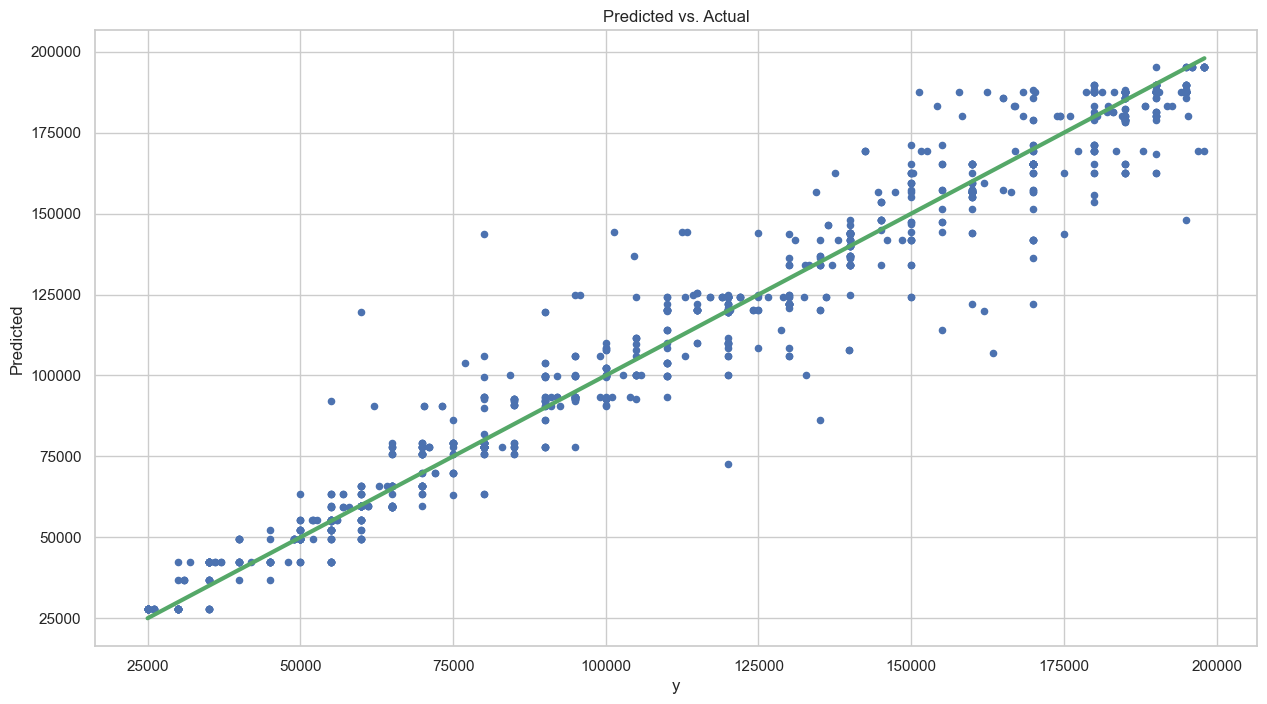

In [363]:
# Create a color map for genders
# colors = []
# for index ,row in X_test.iterrows():
#     if row['Gender_M'] == 1:
#         colors.append('blue')
#     elif row['Gender_F'] == 1:
#         colors.append('red')
#     elif row['Gender_O'] == 1:
#         colors.append('green')
#     else:
#         colors.append('gray')

plt.figure()
amin, amax = min(X_test['y']), max(X_test['y'])
ax = X_test.plot('y', 'Predicted', kind='scatter',
                    #    c=colors, 
                    #  xlim=[amin, amax], ylim=[amin, amax],
                     title='Predicted vs. Actual',
                     figsize = (15,8))
ax.plot(np.linspace(amin, amax, 2), np.linspace(amin, amax, 2),
        linewidth=3, color='g')                    

### **KNN Model**

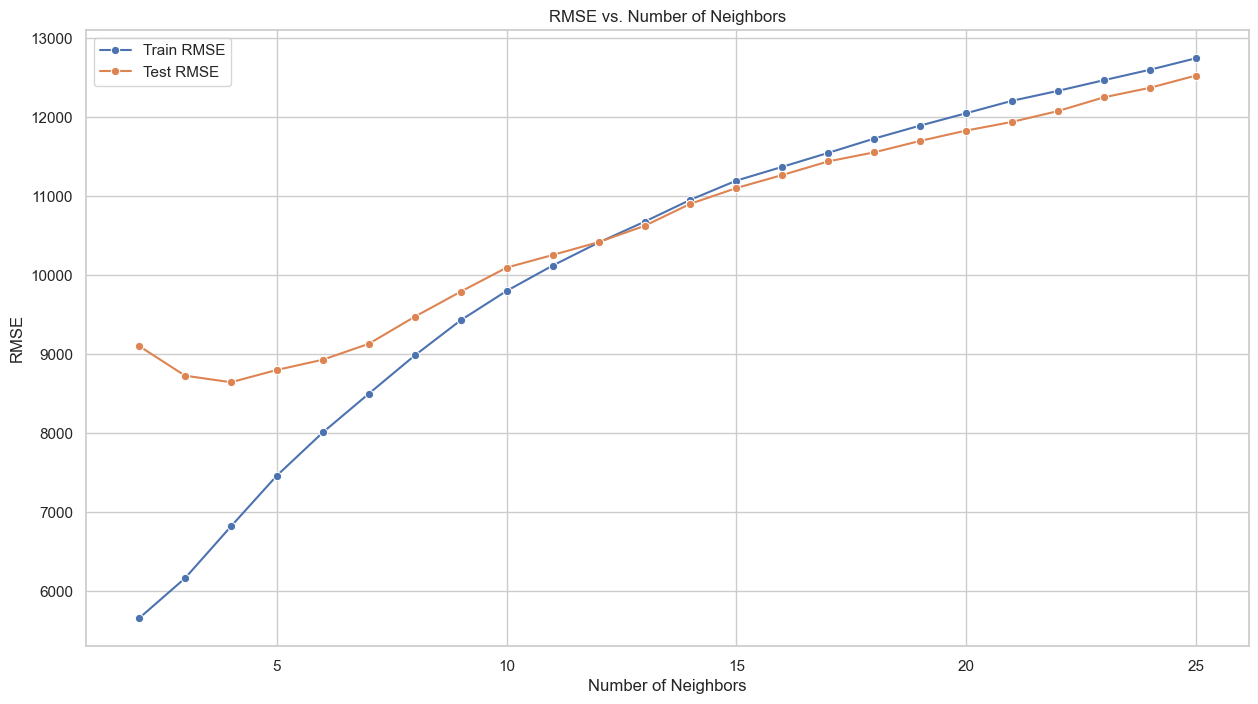

In [349]:


# Define features and target
X = data[['Years_of_Experience','professionalism','Education_Level','job_title_frequency']]
y = data.Salary

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

n_neighbors= []
rmse_train_l = []
rmse_test_l = []

for i in range(2,26):

    # Create a KNeighborsRegressor model
    model = KNeighborsRegressor(n_neighbors=i)  # You can adjust the number of neighbors

    # Train the model on the training data
    model.fit(X_train_scaled, y_train)

    # Make predictions on the train data
    y_pred_train = model.predict(X_train_scaled)

    # Make predictions on the test data
    y_pred_test = model.predict(X_test_scaled)

    # Calculate RMSE
    rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
    rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

    n_neighbors.append(i) 
    rmse_train_l.append(rmse_train)
    rmse_test_l.append(rmse_test)

    # You can add the predicted salaries back to the DataFrame if needed
    # data['Predicted_Salary_knn'] = y_pred

    # Print the DataFrame with predicted salaries and RMSE

    # print("Root Mean Squared Error:", rmse)
   

plt.figure(figsize=(15, 8))
sns.lineplot(x=n_neighbors, y=rmse_train_l, marker='o', label='Train RMSE')
sns.lineplot(x=n_neighbors, y=rmse_test_l, marker='o', label='Test RMSE')
# plt.scatter(n_neighbors[np.argmin(rmse_test)], min(rmse_test), color='r', label=f'Min Test RMSE: {min(rmse_test):.2f}')
plt.title('RMSE vs. Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()
plt.show()

### **Decision Tree Regressor Model**

Train Root Mean Squared Error: 16564.91680989406
Test Root Mean Squared Error: 16155.554672336457


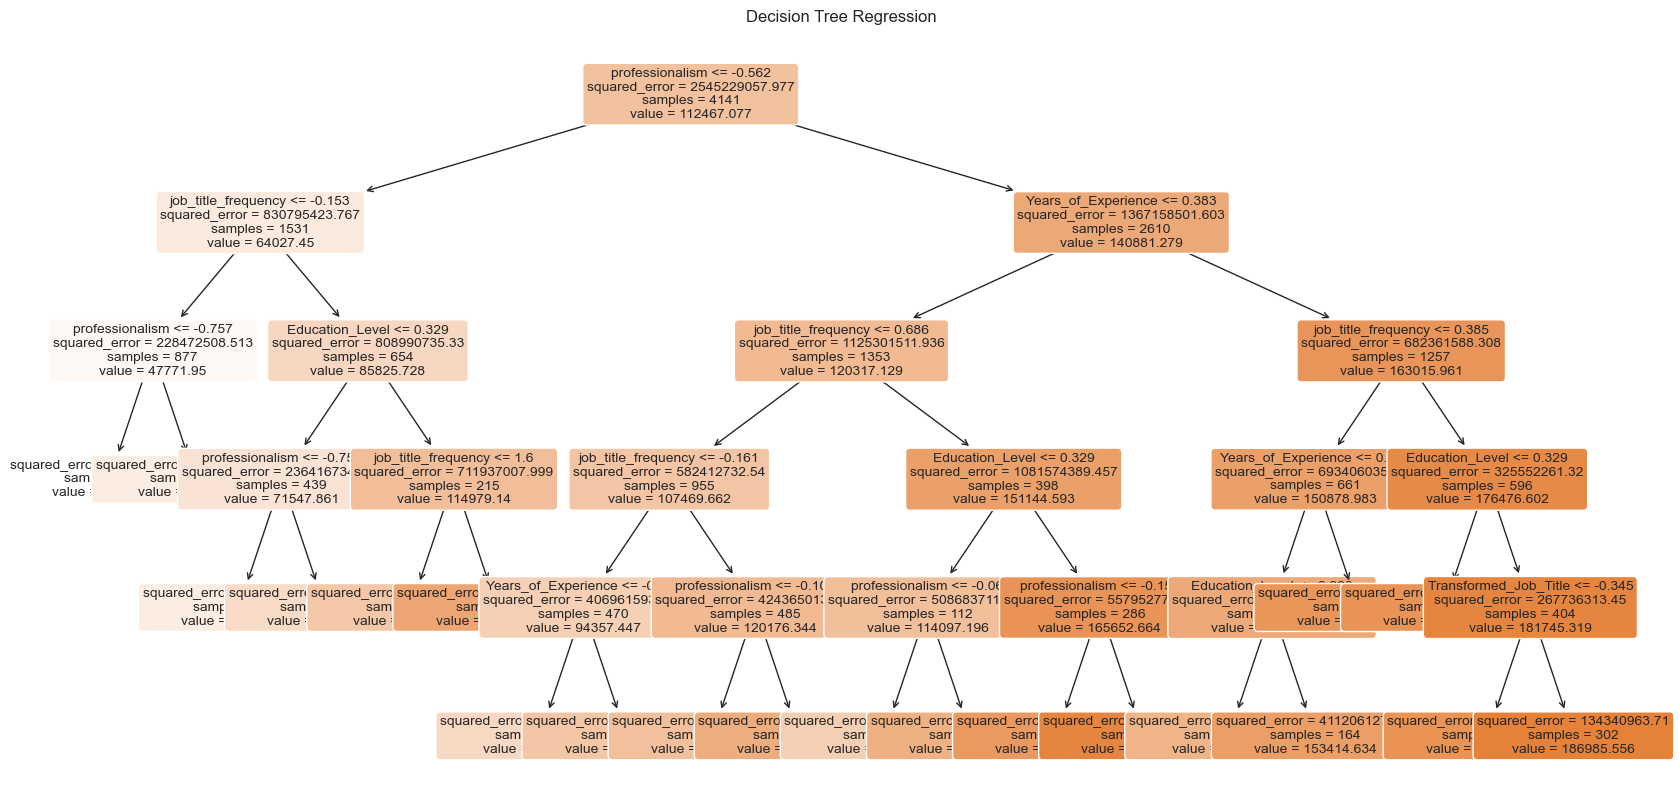

In [350]:


# Assuming you have loaded your data into the 'data' DataFrame

# Define features and target
X = data[['Years_of_Experience', 'professionalism','Education_Level','job_title_frequency','Transformed_Job_Title']]
y = data.Salary

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a DecisionTreeRegressor model
model = DecisionTreeRegressor(max_leaf_nodes=20)  

# Train the model on the entire data
model.fit(X_train_scaled, y_train)

# Make predictions on the train data
y_pred_train = model.predict(X_train_scaled)

# Make predictions on the test data
y_pred_test = model.predict(X_test_scaled)

# Calculate RMSE
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

# You can add the predicted salaries back to the DataFrame if needed
# data['Predicted_Salary'] = y_pred

# Print the RMSE
print("Train Root Mean Squared Error:", rmse_train)
print("Test Root Mean Squared Error:", rmse_test)

# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=X_test.columns.tolist(), filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree Regression')
plt.show()
# data

In [351]:
model.feature_importances_

array([0.14062489, 0.63442465, 0.06153044, 0.15992702, 0.00349301])

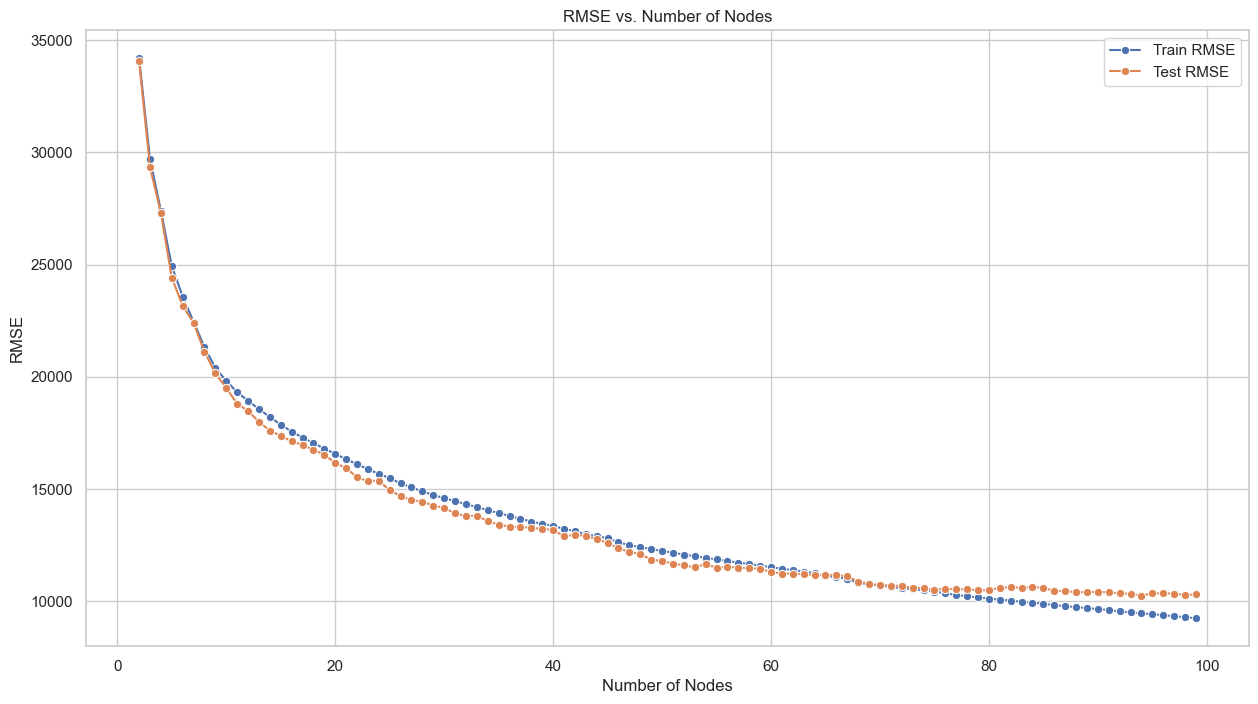

In [352]:
max_leaf_nodes= []
rmse_train_l = []
rmse_test_l = []

for i in range(2, 100):
    # Create a DecisionTreeRegressor model with varying max_leaf_nodes
    model = DecisionTreeRegressor(max_leaf_nodes=i)

    # Train the model on the training data
    model.fit(X_train_scaled, y_train)

    # Make predictions on the train data
    y_pred_train = model.predict(X_train_scaled)

    # Make predictions on the test data
    y_pred_test = model.predict(X_test_scaled)

    # Calculate RMSE for training and test sets
    rmse_train_i = mean_squared_error(y_train, y_pred_train, squared=False)
    rmse_test_i = mean_squared_error(y_test, y_pred_test, squared=False)

    max_leaf_nodes.append(i)
    rmse_train_l.append(rmse_train_i)
    rmse_test_l.append(rmse_test_i)

plt.figure(figsize=(15, 8))
sns.lineplot(x=max_leaf_nodes, y=rmse_train_l, marker='o', label='Train RMSE')
sns.lineplot(x=max_leaf_nodes, y=rmse_test_l, marker='o', label='Test RMSE')
plt.title('RMSE vs. Number of Nodes')
plt.xlabel('Number of Nodes')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()
plt.show()